<a href="https://colab.research.google.com/github/Mattemathics/Machine-Learning-Python/blob/BR-01/CbC_MLP_simamese_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time

In [ ]:
epochs = 10
batch_size = 64
margin = 1  # Margin for constrastive loss.

In [ ]:
data_dim = 28*28
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = np.reshape(x_train,(60000,data_dim))
x_train = tf.keras.utils.normalize(x_train, axis=1)
x_train = np.reshape(x_train,(60000, 28, 28))

x_test = np.reshape(x_test,(10000,data_dim))
x_test = tf.keras.utils.normalize(x_test, axis=1)
x_test = np.reshape(x_test,(10000, 28, 28))

# Change the data type to a floating point format
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")


y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=None, dtype='float32')
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=None, dtype='float32')

ave_x = np.zeros((10, 28, 28))
for i in range(60000):
  ave_x[y_train[i]] = ave_x[y_train[i]] + x_train[i] 

ave_x = np.reshape(ave_x,(10,data_dim))
ave_x = tf.keras.utils.normalize(ave_x, axis=1)
ave_x = np.reshape(ave_x,(10, 28, 28))

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
def make_pairs(x, y):

    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

        # add a non-matching example
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels).astype("float32")


# make train pairs
pairs_train, labels_train = make_pairs(x_train, y_train)

x_train_1 = pairs_train[:, 0] 
x_train_2 = pairs_train[:, 1]

In [ ]:
#Define and train the detection block
feature_number = 10
c =10

from keras import backend as K

def sig_modified(x):
    return K.sigmoid(x)

def innerproduct_similarity(vects):

    x, y = vects
    inner_cal = tf.math.reduce_sum(tf.math.multiply(x, y, name=None), axis=1, keepdims=True)
    return inner_cal

#tf.math.maximum(inner_cal, tf.keras.backend.epsilon())


input_data = layers.Input((28, 28, 1))
x = tf.keras.layers.BatchNormalization()(input_data)
x = layers.Conv2D(4, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(16, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(feature_number, activation="tanh")(x)
feature_extractor_data = keras.Model(inputs= input_data, outputs= x)


input_1 = layers.Input((28, 28, 1))
input_2 = layers.Input((28, 28, 1))

tower_1 = feature_extractor_data(input_1)
tower_2 = feature_extractor_data(input_2)
innerproduct_layer = layers.Lambda(innerproduct_similarity, name="merge")([tower_1, tower_2])
outoput_layer = layers.Dense(1, activation= sig_modified)(innerproduct_layer)
detection = keras.Model(inputs= [input_1, input_2], outputs=outoput_layer)

feature = keras.Model(inputs = input_1, outputs=tower_1)

#detection.summary()

In [ ]:
def loss(margin=1):
  
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing constrastive loss as floating point value.
        """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [ ]:
def myloss(y_true, y_pred):
    cce = tf.keras.losses.CategoricalCrossentropy()
    y_predd = y_pred/(1-y_pred)
    return cce(y_true, y_predd)

In [ ]:
detection.compile(loss=loss(margin=1), optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), metrics=["accuracy"])

In [ ]:
detection.trainable = True
history = detection.fit(
    [x_train_1, x_train_2],
    labels_train,
    batch_size=batch_size,
    epochs=5,
)

Epoch 1/5
1875/1875 [==============================] - 17s 4ms/step - loss: 0.0674 - accuracy: 0.9043
Epoch 2/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0269 - accuracy: 0.9664
Epoch 3/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0235 - accuracy: 0.9695
Epoch 4/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0226 - accuracy: 0.9708
Epoch 5/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0216 - accuracy: 0.9721


In [ ]:
###neural network architecture based on the detection block
c = 10
k = 10
p= 0.5
data_dim = 28*28

def sig_modi(x):
    return 2 * K.sigmoid(x) -1

input_x = layers.Input((28, 28, 1))

input_w1 = layers.Input((1))
w1_vector = layers.Dense(data_dim, use_bias=False, kernel_constraint=tf.keras.constraints.max_norm(p))(input_w1)
w1_image = tf.keras.layers.Reshape((28, 28, 1))(w1_vector)
dec1  = sig_modi(detection([input_x, w1_image]))
input_w2 = layers.Input((1))
w2_vector = layers.Dense(data_dim, use_bias=False, kernel_constraint=tf.keras.constraints.max_norm(p))(input_w2)
w2_image = tf.keras.layers.Reshape((28, 28, 1))(w2_vector)
dec2  = sig_modi(detection([input_x, w2_image]))
input_w3 = layers.Input((1))
w3_vector = layers.Dense(data_dim, use_bias=False, kernel_constraint=tf.keras.constraints.max_norm(p))(input_w3)
w3_image = tf.keras.layers.Reshape((28, 28, 1))(w3_vector)
dec3  = sig_modi(detection([input_x, w3_image]))
input_w4 = layers.Input((1))
w4_vector = layers.Dense(data_dim, use_bias=False, kernel_constraint=tf.keras.constraints.max_norm(p))(input_w4)
w4_image = tf.keras.layers.Reshape((28, 28, 1))(w4_vector)
dec4  = sig_modi(detection([input_x, w4_image]))
input_w5 = layers.Input((1))
w5_vector = layers.Dense(data_dim, use_bias=False, kernel_constraint=tf.keras.constraints.max_norm(p))(input_w5)
w5_image = tf.keras.layers.Reshape((28, 28, 1))(w5_vector)
dec5  = sig_modi(detection([input_x, w5_image]))

input_w6 = layers.Input((1))
w6_vector = layers.Dense(data_dim, use_bias=False, kernel_constraint=tf.keras.constraints.max_norm(p))(input_w6)
w6_image = tf.keras.layers.Reshape((28, 28, 1))(w6_vector)
dec6  = sig_modi(detection([input_x, w6_image]))

input_w7 = layers.Input((1))
w7_vector = layers.Dense(data_dim, use_bias=False, kernel_constraint=tf.keras.constraints.max_norm(p))(input_w7)
w7_image = tf.keras.layers.Reshape((28, 28, 1))(w7_vector)
dec7  = sig_modi(detection([input_x, w7_image]))

input_w8 = layers.Input((1))
w8_vector = layers.Dense(data_dim, use_bias=False, kernel_constraint=tf.keras.constraints.max_norm(p))(input_w8)
w8_image = tf.keras.layers.Reshape((28, 28, 1))(w8_vector)
dec8  = sig_modi(detection([input_x, w8_image]))

input_w9 = layers.Input((1))
w9_vector = layers.Dense(data_dim, use_bias=False, kernel_constraint=tf.keras.constraints.max_norm(p))(input_w9)
w9_image = tf.keras.layers.Reshape((28, 28, 1))(w9_vector)
dec9  = sig_modi(detection([input_x, w9_image]))

input_w10 = layers.Input((1))
w10_vector = layers.Dense(data_dim, use_bias=False, kernel_constraint=tf.keras.constraints.max_norm(p))(input_w10)
w10_image = tf.keras.layers.Reshape((28, 28, 1))(w10_vector)
dec10  = sig_modi(detection([input_x, w10_image]))


concat = tf.keras.layers.Concatenate(axis=1)([dec1, dec2, dec3, dec4, dec5, dec6, dec7, dec8, dec9, dec10])
output = layers.Dense(c, activation= 'sigmoid', kernel_initializer=tf.keras.initializers.Zeros(), use_bias=False)(concat)
prob_classifier = keras.Model(inputs= [input_x, input_w1, input_w2, input_w3, input_w4, input_w5, input_w6, input_w7, input_w8, input_w9, input_w10], outputs=output)
prob_classifier.compile(loss=myloss, optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=["categorical_accuracy"])

#detection.summary()
#prob_classifier.summary()
#keras.utils.plot_model(prob_classifier)

In [ ]:
prob_classifier.layers[10].set_weights(ave_x[0].reshape(1,1,784))
prob_classifier.layers[11].set_weights(ave_x[1].reshape(1,1,784))
prob_classifier.layers[12].set_weights(ave_x[2].reshape(1,1,784))
prob_classifier.layers[13].set_weights(ave_x[3].reshape(1,1,784))
prob_classifier.layers[14].set_weights(ave_x[4].reshape(1,1,784))
prob_classifier.layers[15].set_weights(ave_x[5].reshape(1,1,784))
prob_classifier.layers[16].set_weights(ave_x[6].reshape(1,1,784))
prob_classifier.layers[17].set_weights(ave_x[7].reshape(1,1,784))
prob_classifier.layers[18].set_weights(ave_x[8].reshape(1,1,784))
prob_classifier.layers[19].set_weights(ave_x[9].reshape(1,1,784))

In [ ]:
#training phase
inp = np.ones(shape=(60000, 1))
inpp = np.ones(shape=(10000, 1))
detection.trainable = False

for ru in range(1):
  prob_classifier.layers[10].trainable = False
  prob_classifier.layers[11].trainable = False
  prob_classifier.layers[12].trainable = False
  prob_classifier.layers[13].trainable = False
  prob_classifier.layers[14].trainable = False
  prob_classifier.layers[15].trainable = False
  prob_classifier.layers[16].trainable = False
  prob_classifier.layers[17].trainable = False
  prob_classifier.layers[18].trainable = False
  prob_classifier.layers[19].trainable = False
  prob_classifier.layers[-1].trainable = True
  history1 = prob_classifier.fit(
      [x_train, inp, inp, inp, inp, inp, inp, inp, inp, inp, inp],
      y_train_cat,
      validation_data=([x_test, inpp, inpp, inpp, inpp, inpp, inpp, inpp, inpp, inpp, inpp], y_test_cat),
      batch_size=batch_size,
      epochs=2,
  )
  prob_classifier.layers[10].trainable = True
  prob_classifier.layers[11].trainable = True
  prob_classifier.layers[12].trainable = True
  prob_classifier.layers[13].trainable = True
  prob_classifier.layers[14].trainable = True
  prob_classifier.layers[15].trainable = True
  prob_classifier.layers[16].trainable = True
  prob_classifier.layers[17].trainable = True
  prob_classifier.layers[18].trainable = True
  prob_classifier.layers[19].trainable = True
  prob_classifier.layers[-1].trainable = False
  history1 = prob_classifier.fit(
      [x_train, inp, inp, inp, inp, inp, inp, inp, inp, inp, inp],
      y_train_cat,
      validation_data=([x_test, inpp, inpp, inpp, inpp, inpp, inpp, inpp, inpp, inpp, inpp], y_test_cat),
      batch_size=batch_size,
      epochs=1,
  )


Epoch 1/2
938/938 [==============================] - 14s 15ms/step - loss: 0.7933 - categorical_accuracy: 0.9021 - val_loss: 0.6953 - val_categorical_accuracy: 0.9071
Epoch 2/2
938/938 [==============================] - 14s 15ms/step - loss: 0.5333 - categorical_accuracy: 0.9100 - val_loss: 0.4773 - val_categorical_accuracy: 0.9114


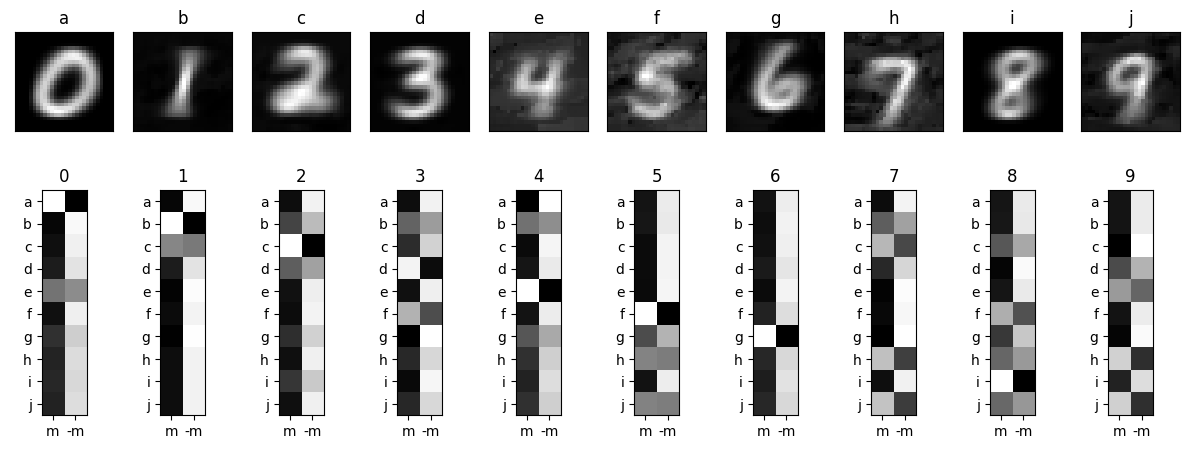

In [ ]:
plt.figure(figsize=(12, 5), dpi=100)
tit = ['a','b','c','d','e','f','g','h','i','j']
num = ['0','1','2','3','4','5','6','7','8','9']
for ii in range(10):
  plt.subplot(2,10,1+ii)
  image = prob_classifier.layers[10+ii].get_weights()[0]
  plt.imshow(image.reshape(28,28), cmap='gray')
  plt.xticks([])
  plt.yticks([])
  plt.title(tit[ii])



reasoning = prob_classifier.layers[-1].get_weights()[0]

for jj in range(10):
  plt.subplot(2,10,11+jj)
  pos = np.transpose(reasoning)[jj]
  neg = - pos
  mat = np.transpose([pos, neg])
  plt.yticks([0, 1, 2, 3, 4, 5, 6, 7 ,8, 9], ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j'])
  plt.xticks([0,1],['m', '-m'])
  plt.imshow(mat, cmap='gray')
  plt.title(num[jj])

plt.tight_layout()